In [ ]:
import catanatron_gym.envs.catanatron_env as catan_env 
# from catanatron_experimental.machine_learning.palyers.value import ValueFunctionPlayer
import catanatron_experimental.machine_learning.players.value as value
from catanatron.models.player import Color

In [58]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class LossCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossCallback, self).__init__(verbose)
        self.losses = []

    def _on_step(self) -> bool:
        # 获取当前的损失值
        loss = self.model.logger.name_to_value.get('train/loss', None)
        if loss is not None:
            self.losses.append(loss)
            if self.verbose > 0:
                print(f"Step: {self.num_timesteps}, Loss: {loss}")
        return True

    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel('Timesteps')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.show()


from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0.0

    def _on_step(self) -> bool:
        # 累积当前 step 的奖励
        self.current_episode_reward += self.locals['rewards'][0]
        
        # 如果 episode 结束，记录总奖励
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0.0  # 重置当前 episode 的奖励
        return True

    def _on_training_end(self) -> None:
        plt.plot(self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Rewards per Episode')
        plt.show()



In [83]:
from catanatron.state_functions import get_actual_victory_points

def reward_f(game, p0_color):
    currentTurn = game.state.current_turn_index
    currentScore = get_actual_victory_points(game.state, p0_color) 
    
    return currentScore

    # game.state.player_state state.player_state[f"{key}_ACTUAL_VICTORY_POINTS"]



In [75]:
from stable_baselines3.common.policies import ActorCriticPolicy
import torch as th

class CustomPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs)
        self.action_mask = None

    def forward(self, obs, deterministic=False):
        actions, values, log_prob = super(CustomPolicy, self).forward(obs, deterministic)
        if self.action_mask is not None:
            mask = th.tensor(self.action_mask, dtype=th.bool, device=actions.device)
            actions = actions.masked_fill(~mask, -1e9)
        return actions, values, log_prob

    def set_action_mask(self, mask):
        self.action_mask = mask

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | -9.88    |
| time/              |          |
|    fps             | 577      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -10.1       |
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016252618 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.2         |
|    entropy_loss  

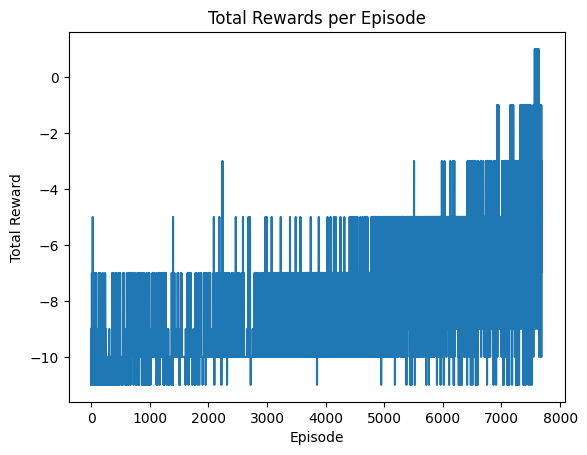

In [76]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


# 创建环境
# env = gym.make('CartPole-v1')
env = catan_env.CatanatronEnv(config={
    # 'enemies': [value.ValueFunctionPlayer(Color.RED)],
    'reward_function': reward_f
})

# 创建 PPO 模型
model = PPO(CustomPolicy, env, verbose=1)

# lossCallBack = LossCallback(verbose=1)
reward_callback = RewardCallback()
# 训练模型
model.learn(total_timesteps=100000, callback=reward_callback)

# 保存模型
model.save("ppo_cartpole")



In [77]:
# 加载模型
model = PPO.load("ppo_cartpole")

# # 评估模型
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

/home/smokingmouse/miniconda3/envs/ai-learning/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -5.2 +/- 1.661324772583615


In [78]:
print(reward_callback.episode_rewards)

[-9.0, -10.0, -11.0, -11.0, -10.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, -10.0, -10.0, -7.0, -10.0, -10.0, -10.0, -9.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -5.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -11.0, -10.0, -10.0, -10.0, -10.0, -7.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -10.0, -11.0, -10.0, -10.0, -7.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -10.0, -11.0, -7.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -9.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -9.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, -10.0, -10.0, -10.0, -10.0, -7.0, -10.0, -11.0, -11.0, -7.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -11.0, 

In [80]:
model = PPO.load("ppo_cartpole")

In [81]:
import torch as th
device = "cuda" if th.cuda.is_available() else "cpu"

In [82]:
import random
import numpy as np
import torch as th

observation, info = env.reset()
print(env.game.id)
for _ in range(10000):
    valid_actions = env.get_valid_actions()
    action_mask = np.zeros(env.action_space.n, dtype=bool)
    action_mask[valid_actions] = True

    # 获取模型的动作概率分布
    obs_tensor = th.tensor([observation], dtype=th.float32).to(device)
    with th.no_grad():
        action_dist = model.policy.get_distribution(obs_tensor)
        action_probs = action_dist.distribution.probs.detach().cpu().numpy()[0]

    # 只保留有效动作的概率
    masked_action_probs = action_probs * action_mask
    masked_action_probs /= masked_action_probs.sum()  # 归一化

    # 根据掩码后的概率分布选择动作
    action = np.random.choice(env.action_space.n, p=masked_action_probs)
    
    # print(f"Selected action: {catan_env.ACTIONS_ARRAY[action]}")
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print(f"Episode finished, winner: {env.game.winning_color(), get_actual_victory_points(env.game.state, env.enemies[0].color)} & score{get_actual_victory_points(env.game.state, env.p0.color)}")
        obs = env.reset()

env.close()

5deb6f9e-5ec3-4276-897e-eb7fede48efe
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score4
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 9) & score10
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 6) & score10
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score5
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 3) & score10
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score3
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 8) & score10
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 2) & score10
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score4
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score6
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score8
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 3) & score10
Episode finished, winner: (<Color.BLUE: 'BLUE'>, 2) & score10
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score9
Episode finished, winner: (<Color.RED: 'RED'>, 10) & score7
Episode finished, winner: (<Color.RED: 'RED'>, 10